In [0]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,10

In [0]:
#Reading the data
data=pd.read_csv('/content/drive/My Drive/novel-corona-virus-2019-dataset/covid_19_data.csv')

In [0]:
#Dropping the columns Sno and Last Update
data.drop(['SNo','Last Update'],axis=1,inplace=True)

In [0]:
#Getting additonal Active cases for better implementation and information
data['Active']=data['Confirmed']-data['Deaths']-data['Recovered']

In [5]:
#Checking for NA values
data.isna().sum()

ObservationDate       0
Province/State     4433
Country/Region        0
Confirmed             0
Deaths                0
Recovered             0
Active                0
dtype: int64

In [6]:
#Filling NA Values
data['Province/State']=data['Province/State'].fillna('Not Specified')
data.isna().sum()

ObservationDate    0
Province/State     0
Country/Region     0
Confirmed          0
Deaths             0
Recovered          0
Active             0
dtype: int64

In [7]:
data['Province/State'].value_counts()

Not Specified                   4433
Diamond Princess cruise ship      82
Hebei                             69
Gansu                             69
Shanxi                            67
                                ... 
Bennington County, VT              1
Travis, CA                         1
Fench Guiana                       1
Collin County, TX                  1
Turks and Caicos Islands           1
Name: Province/State, Length: 294, dtype: int64

In [8]:
data.dtypes

ObservationDate     object
Province/State      object
Country/Region      object
Confirmed          float64
Deaths             float64
Recovered          float64
Active             float64
dtype: object

In [0]:
data['Confirmed']=data['Confirmed'].astype(int)
data['Recovered']=data['Recovered'].astype(int)
data['Deaths']=data['Deaths'].astype(int)
data['Active']=data['Active'].astype(int)

In [10]:
data.dtypes

ObservationDate    object
Province/State     object
Country/Region     object
Confirmed           int64
Deaths              int64
Recovered           int64
Active              int64
dtype: object

In [11]:
china_cases=data[data['ObservationDate']==max(data['ObservationDate'])].reset_index(drop=True)
china_cases=china_cases.groupby('Country/Region')['Active'].sum()['Mainland China']
china_cases

3128

In [12]:
data_nc=data[data['Country/Region']!='Mainland China']
data_nc

,ObservationDate,Province/State,Country/Region,Confirmed,Deaths,Recovered,Active
12,01/22/2020,Hong Kong,Hong Kong,0,0,0,0
20,01/22/2020,Macau,Macau,1,0,0,1
28,01/22/2020,Taiwan,Taiwan,1,0,0,1
31,01/22/2020,Washington,US,1,0,0,1
35,01/22/2020,Not Specified,Japan,2,0,0,2
...,...,...,...,...,...,...,...
9727,03/28/2020,West Virginia,US,96,0,0,96
9728,03/28/2020,Western Australia,Australia,278,2,28,248
9729,03/28/2020,Wisconsin,US,1055,17,0,1038
9730,03/28/2020,Wyoming,US,82,0,0,82


In [0]:
data_per_day=data.groupby('ObservationDate')[['Confirmed','Deaths','Recovered','Active']].sum()
data_per_day_nc=data_nc.groupby('ObservationDate')[['Confirmed','Deaths','Recovered','Active']].sum()

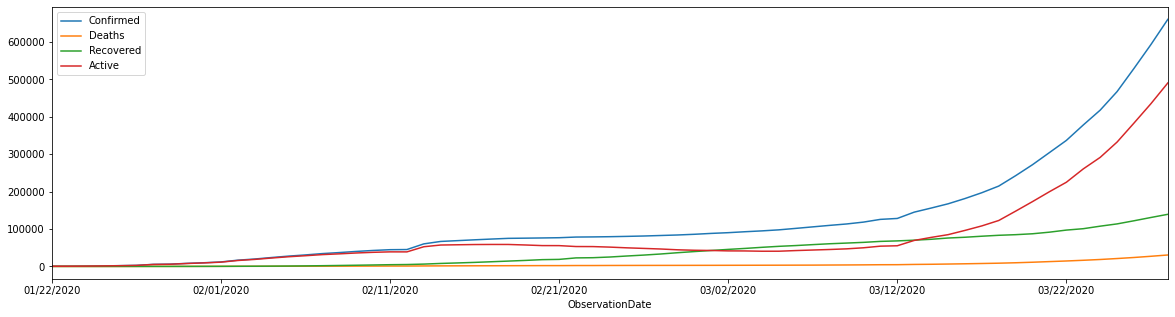

In [14]:
data_per_day.plot(kind='line',figsize=(20,5))

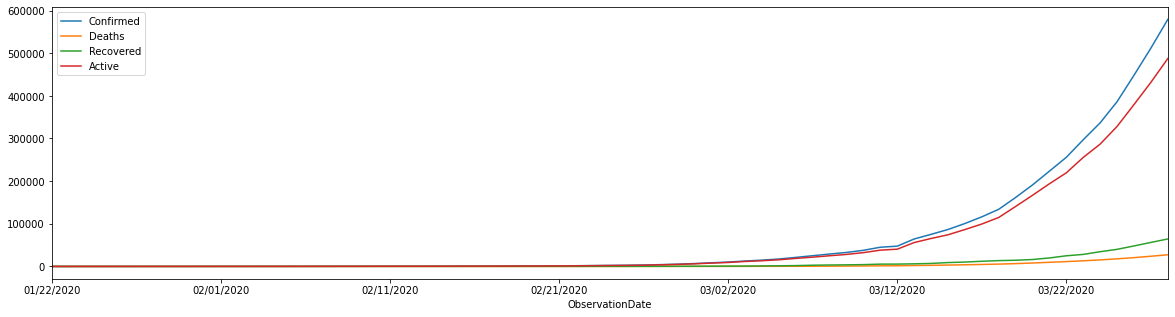

In [15]:
data_per_day_nc.plot(kind='line',figsize=(20,5))

In [0]:
from fbprophet import Prophet

p=Prophet()

In [17]:
p.add_seasonality(name='monthly',period=30.5,fourier_order=5)

In [18]:
print(data_per_day.shape)

cases=data_per_day.reset_index()
cases.tail()

(67, 4)


,ObservationDate,Confirmed,Deaths,Recovered,Active
62,03/24/2020,417966,18615,107705,291646
63,03/25/2020,467594,21181,113770,332643
64,03/26/2020,529591,23970,122150,383471
65,03/27/2020,593291,27198,130915,435178
66,03/28/2020,660706,30652,139415,490639


In [0]:
cases_nc=data_per_day_nc.reset_index()

In [0]:
confirmed_cases=cases_nc[['ObservationDate','Confirmed']]
recovered_cases=cases_nc[['ObservationDate','Recovered']]
death_cases=cases_nc[['ObservationDate','Deaths']]
active_cases=cases_nc[['ObservationDate','Active']]

In [21]:
active_cases.rename(columns={'ObservationDate':'ds','Active':'y'},inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4238: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
#Fit Model
p.fit(active_cases)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
#Future Dates
future_dates=p.make_future_dataframe(periods=30)
future_dates

,ds
0,2020-01-22
1,2020-01-23
2,2020-01-24
3,2020-01-25
4,2020-01-26
...,...
92,2020-04-23
93,2020-04-24
94,2020-04-25
95,2020-04-26


In [0]:
#Prediction
prediction=p.predict(future_dates)

Text(0.5, 1.0, 'Predicted Number of Active Cases')

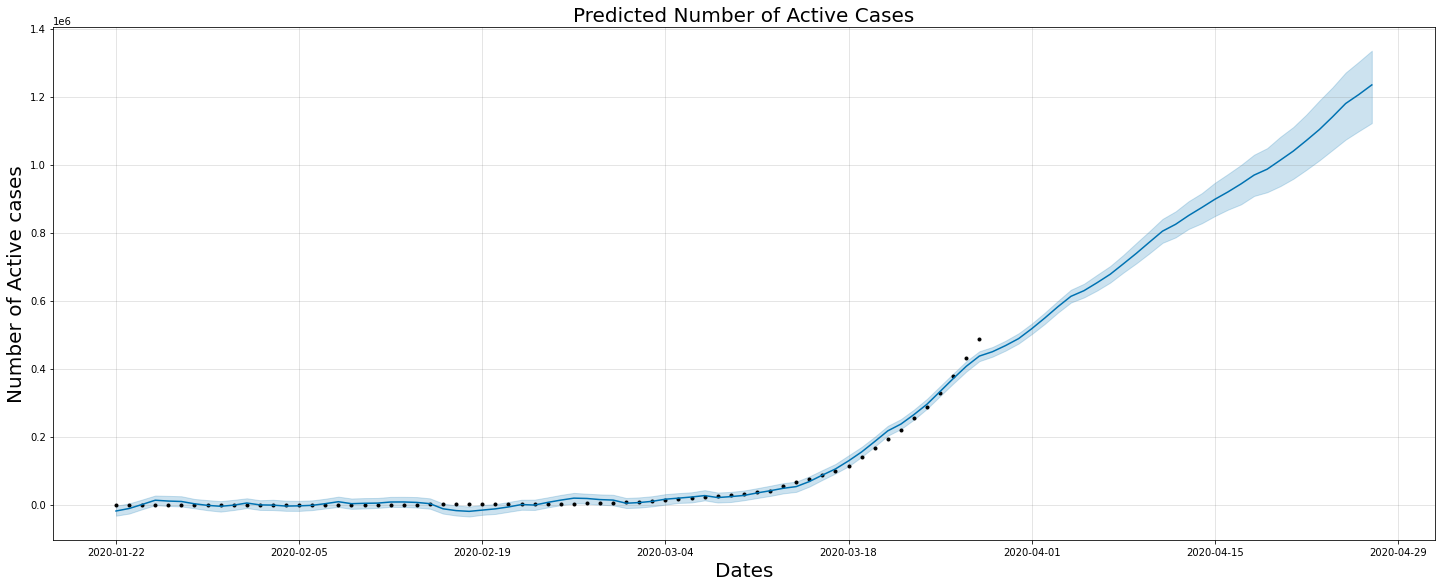

In [37]:
#Plot Prediction
p.plot(prediction,figsize=(20,8))
plt.xlabel('Dates',size=20)
plt.ylabel('Number of Active cases',size=20)
plt.title('Predicted Number of Active Cases',size=20)

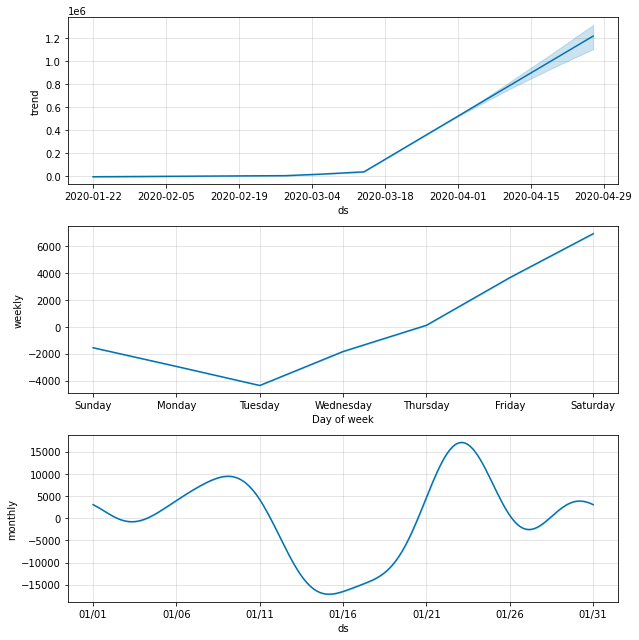

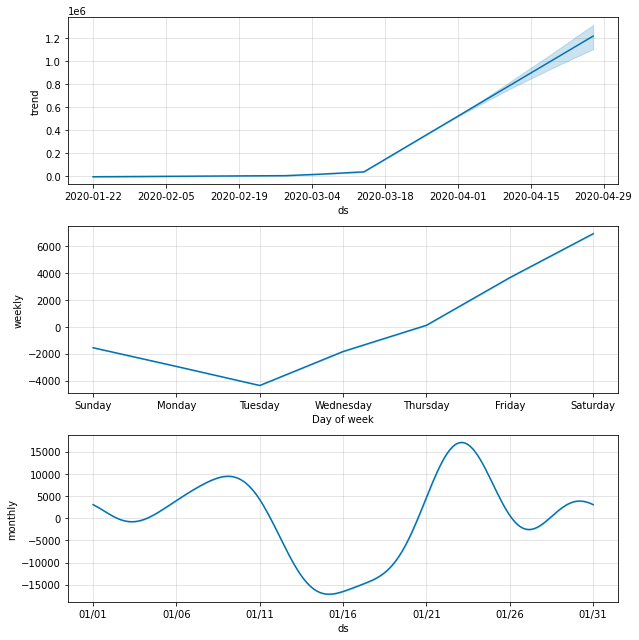

In [26]:
p.plot_components(prediction)

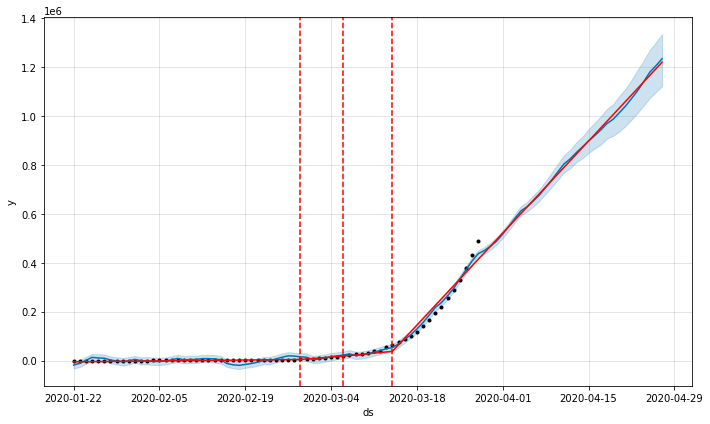

In [27]:
#Find Points/Dates for change
from fbprophet.plot import add_changepoints_to_plot
fig=p.plot(prediction)
c=add_changepoints_to_plot(fig.gca(),p,prediction)

In [28]:
prediction.tail().T

,92,93,94,95,96
ds,2020-04-23 00:00:00,2020-04-24 00:00:00,2020-04-25 00:00:00,2020-04-26 00:00:00,2020-04-27 00:00:00
trend,1.11282e+06,1.1397e+06,1.16658e+06,1.19347e+06,1.22035e+06
yhat_lower,1.01277e+06,1.04311e+06,1.07362e+06,1.09828e+06,1.12217e+06
yhat_upper,1.18868e+06,1.22748e+06,1.2708e+06,1.30229e+06,1.3351e+06
trend_lower,1.02377e+06,1.0445e+06,1.06507e+06,1.08533e+06,1.10514e+06
trend_upper,1.19127e+06,1.22442e+06,1.25557e+06,1.28607e+06,1.31702e+06
additive_terms,-9313.44,947.495,13158.8,12519.9,14143.2
additive_terms_lower,-9313.44,947.495,13158.8,12519.9,14143.2
additive_terms_upper,-9313.44,947.495,13158.8,12519.9,14143.2
monthly,-9429.17,-2716.33,6225.35,14076.6,17092.2


In [29]:
prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
92,2020-04-23,1.103505e+06,1.012768e+06,1.188678e+06
93,2020-04-24,1.140648e+06,1.043113e+06,1.227484e+06
94,2020-04-25,1.179742e+06,1.073624e+06,1.270804e+06
95,2020-04-26,1.205986e+06,1.098279e+06,1.302292e+06
96,2020-04-27,1.234492e+06,1.122168e+06,1.335100e+06


In [30]:
print('Prediction of Deaths for',prediction['ds'][95],'is ',round(prediction['yhat'][95]))

Prediction of Deaths for 2020-04-26 00:00:00 is  1205986.0


In [31]:
k=len(prediction)
k

97

In [32]:
for i in range(68,k) :
  print('Prediction of Active cases for',prediction['ds'][i],'is ',round(prediction['yhat'][i].astype(int))+china_cases)

Prediction of Active cases for 2020-03-30 00:00:00 is  470975
Prediction of Active cases for 2020-03-31 00:00:00 is  491501
Prediction of Active cases for 2020-04-01 00:00:00 is  520473
Prediction of Active cases for 2020-04-02 00:00:00 is  552025
Prediction of Active cases for 2020-04-03 00:00:00 is  585201
Prediction of Active cases for 2020-04-04 00:00:00 is  615840
Prediction of Active cases for 2020-04-05 00:00:00 is  632520
Prediction of Active cases for 2020-04-06 00:00:00 is  655918
Prediction of Active cases for 2020-04-07 00:00:00 is  680675
Prediction of Active cases for 2020-04-08 00:00:00 is  711207
Prediction of Active cases for 2020-04-09 00:00:00 is  742259
Prediction of Active cases for 2020-04-10 00:00:00 is  775119
Prediction of Active cases for 2020-04-11 00:00:00 is  807498
Prediction of Active cases for 2020-04-12 00:00:00 is  827623
Prediction of Active cases for 2020-04-13 00:00:00 is  853545
Prediction of Active cases for 2020-04-14 00:00:00 is  876932
Predicti

In [33]:
ab=prediction[prediction['ds']>=max(data['ObservationDate'])][['ds','yhat']].reset_index(drop=True)
ab.rename(columns={'ds':'date','yhat':'active_val'},inplace=True)
ab

,date,active_val
0,2020-03-28,4.370171e+05
1,2020-03-29,4.497893e+05
2,2020-03-30,4.678472e+05
3,2020-03-31,4.883740e+05
4,2020-04-01,5.173452e+05
5,2020-04-02,5.488973e+05
6,2020-04-03,5.820736e+05
7,2020-04-04,6.127123e+05
8,2020-04-05,6.293928e+05
9,2020-04-06,6.527902e+05


In [0]:
ad=pd.DataFrame(ab)
ad.to_csv('/content/drive/My Drive/Colab Notebooks/Active Data.csv',index=False)